In [1]:
import PyWGCNA
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
DATA_DIR = ""
FILE_NAME = ""

In [3]:
adata = sc.read(f"{DATA_DIR}/{FILE_NAME}")

In [4]:
adata

AnnData object with n_obs × n_vars = 60 × 5320
    obs: 'sample', 'region', 'region_sample', 'age', 'cause_of_death', 'pmi', 'sex'
    var: 'gene', 'protein_id', 'protein_names', 'n_cells'
    uns: 'neighbors', 'pca', 'region_colors', 'sample_colors', 'sex_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
regions = []
for r in adata.obs["region"]:
    if r == "Calvaria":
        regions.append("Skull")
    else:
        regions.append(r)
adata.obs["region"] = regions
adata.obs["region_sample"] = adata.obs["region"].astype(str) + "_" + adata.obs["sample"].astype(str)

In [7]:
expr = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs["region_sample"])

In [ ]:
pyWGCNA_human = PyWGCNA.WGCNA(name='human', 
                              species='hsapiens', 
                              geneExp=expr, 
                              RsquaredCut=0.8,
                              MEDissThres=0.15,
                              save=True)

#### Pre-processing workflow


Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..



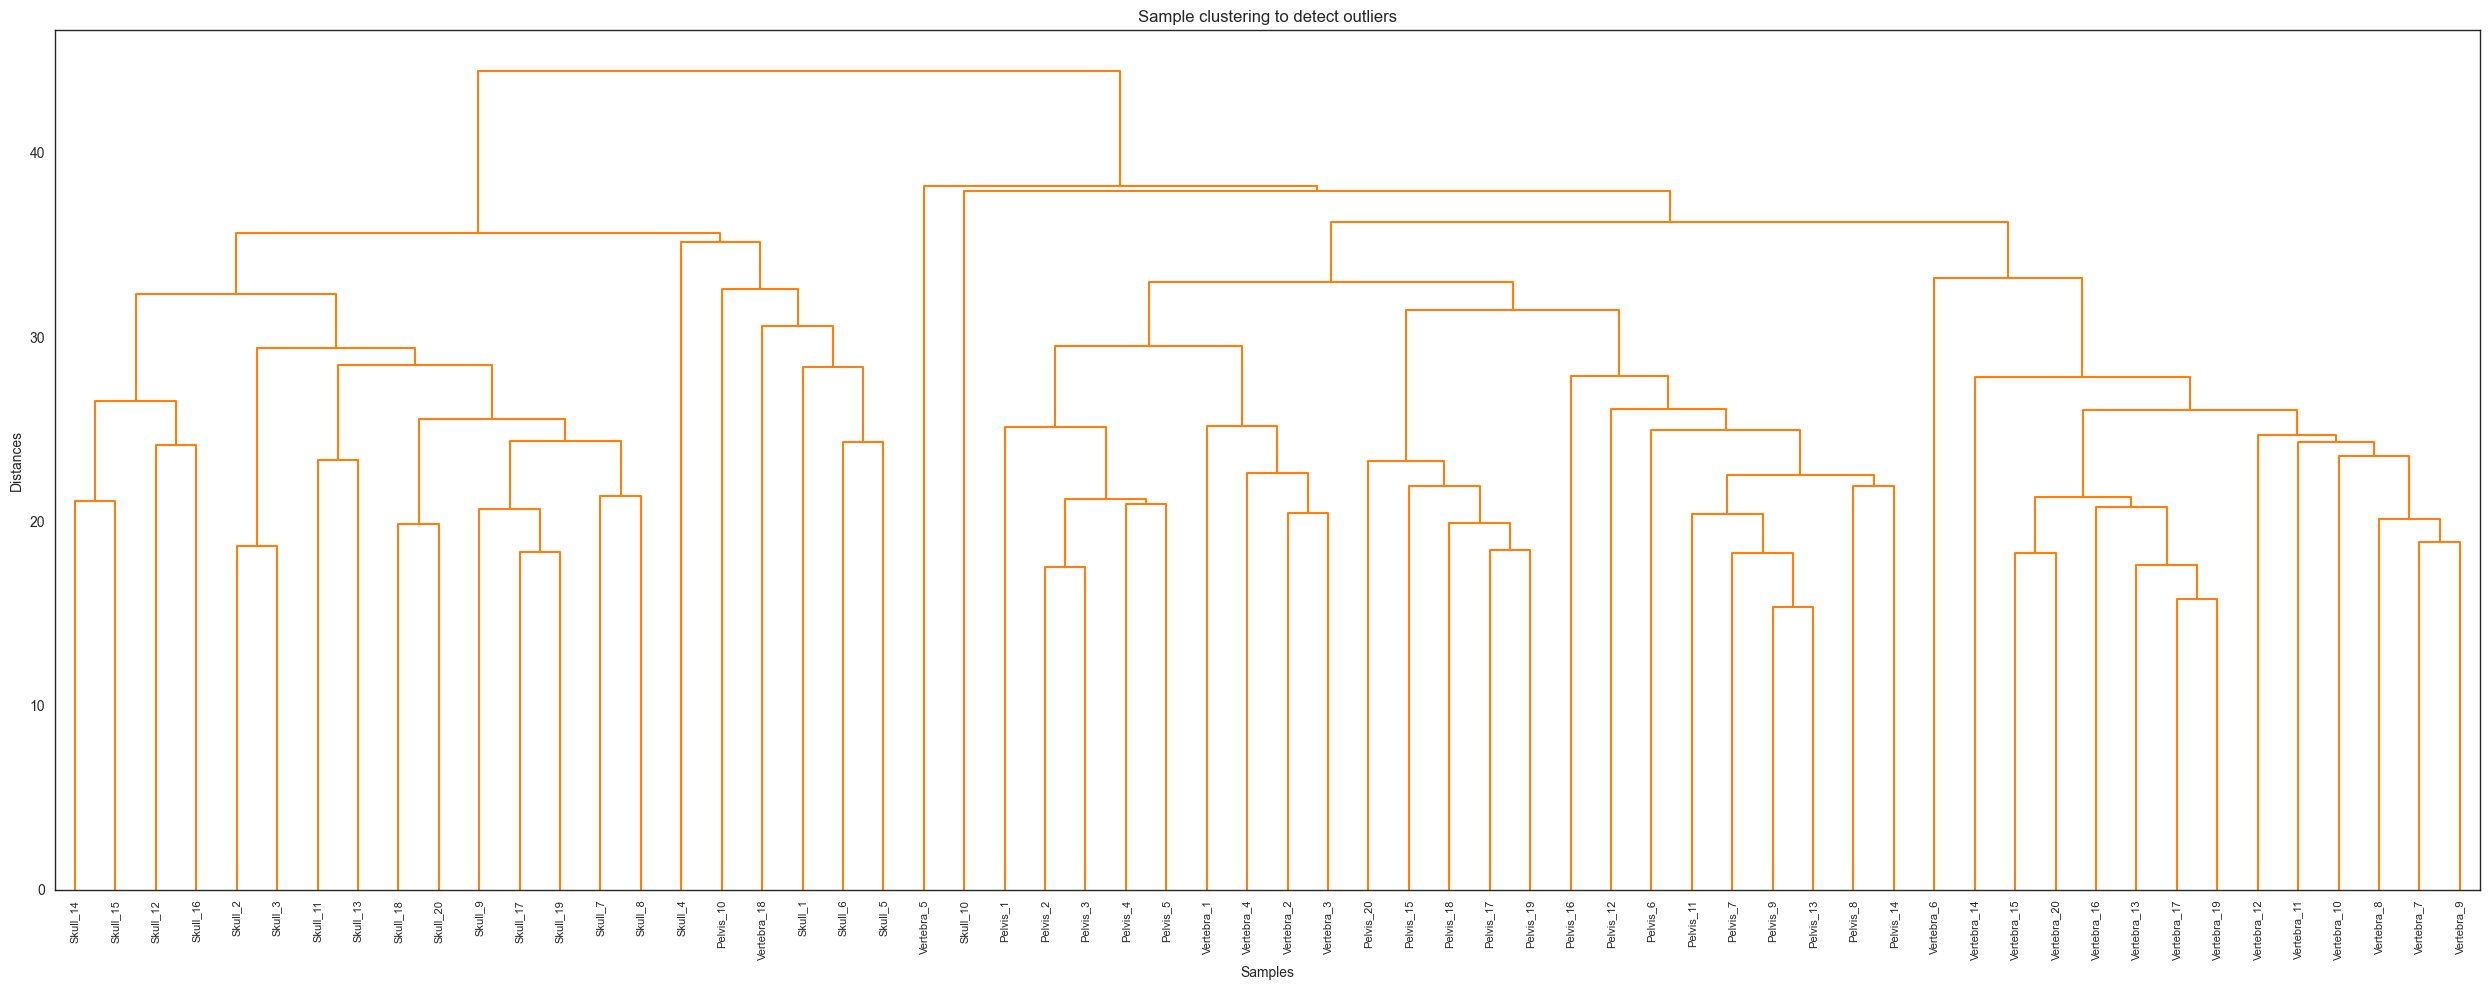

In [9]:
pyWGCNA_human.preprocess()

#### Construction of the gene network and identification of modules
PyWGCNA compresses all the steps of network construction and module detection in one function called findModules which performs the following steps:

1. Choosing the soft-thresholding power: analysis of network topology
2. Co-expression similarity and adjacency
3. Topological Overlap Matrix (TOM)
4. Clustering using TOM
5. Merging of modules whose expression profiles are very similar

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  5320
    Power  SFT.R.sq     slope truncated R.sq      mean(k)    median(k)  \
0       1  0.476455  0.557797       0.332526  1723.387307  1872.296645   
1       2  0.074757 -0.245427       0.299099   842.069242   865.031719   
2       3  0.344865 -0.759765       0.639631   463.438549    439.85304   
3       4  0.489413  -1.10184       0.778266   275.222002   238.244513   
4       5  0.602343 -1.274774       0.865411   172.601434   134.648429   
5       6  0.663697 -1.412032       0.905134    112.84756    79.226137   
6       7  0.697885  -1.52331       0.927162    76.270846    48.382705   
7       8  0.729895 -1.583911       0.944651    52.975281    30.204134   
8       9  0.753092 -1.636822       0.954204    37.648703     19.24906   
9      10  0.762794 -1.690497       0.955854    27.286977    12.547215   
10     11  0.783953 -1.705201       0.966249    20.117313      8.29629   
11     13

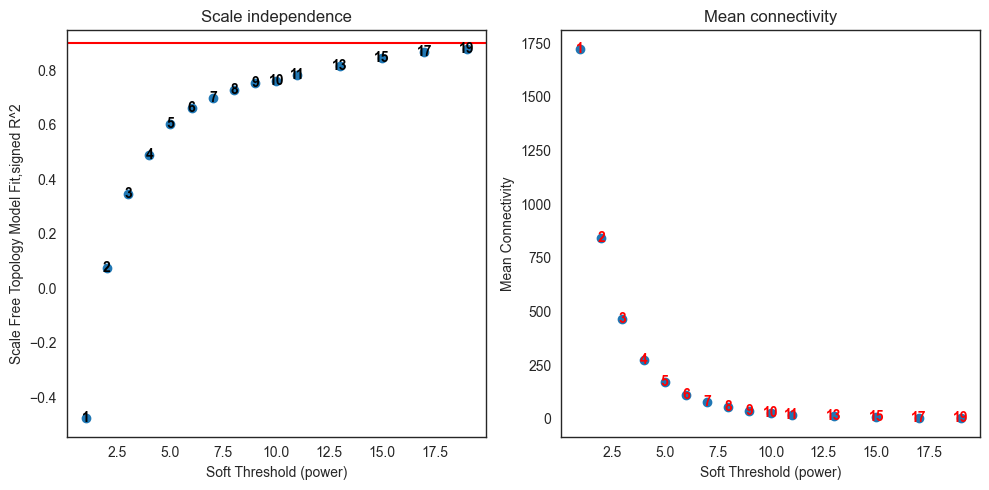

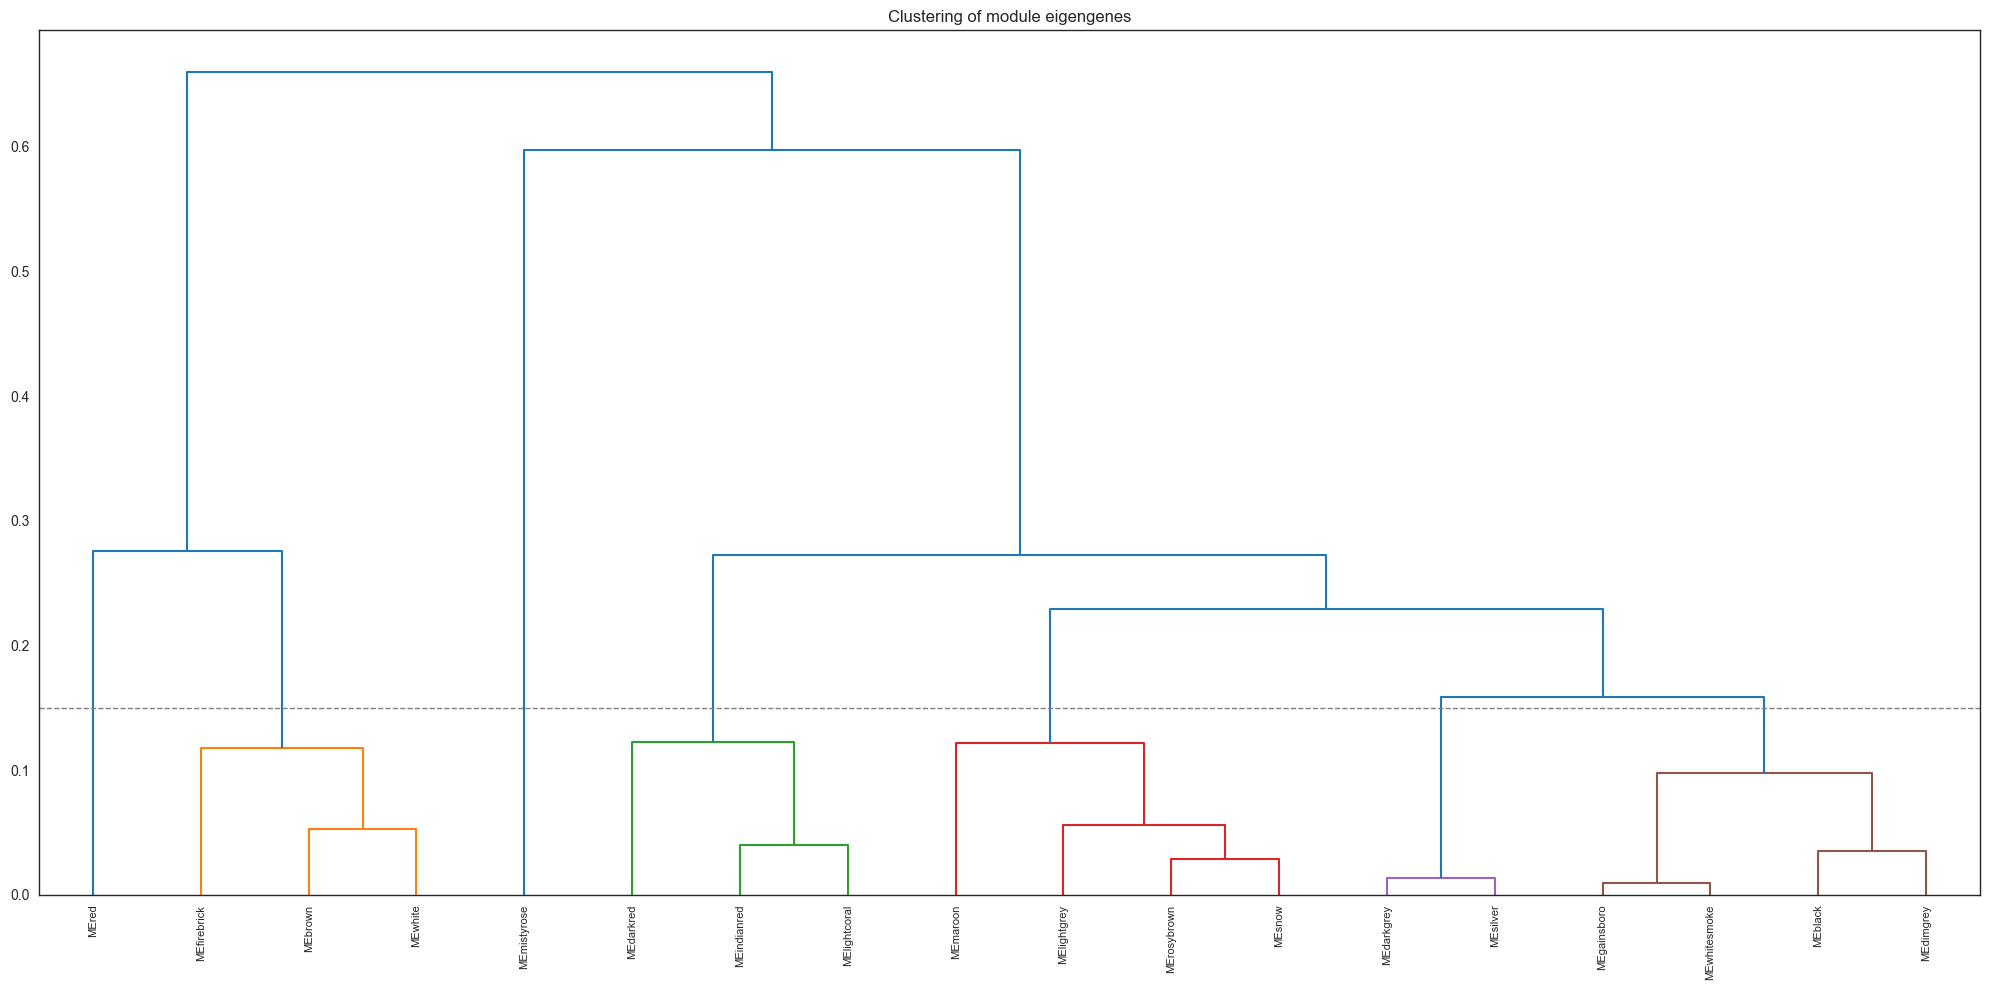

In [10]:
pyWGCNA_human.findModules()

### Relating modules to external information and identifying important genes
PyWGCNA gather some important analysis after identifying modules in analyseWGCNA() function including:

1. Quantifying module–trait relationship
2. Gene relationship to trait and modules
3. Gene-ontology analysis
4. Keep in your mind before you start analysis to add any sample or gene information.

For showing module relationship heatmap, PyWGCNA needs user to choose and set colors from Matplotlib colors for metadata by using setMetadataColor() function.

You also can select which data trait in which order you wish to show in module eigengene heatmap

In [5]:
# adding groups of causes of death
cause_of_death_dict = {
'Polytrauma (Accident)': "traumatic",
'Myocardial infarction': "hypoxic",
'Head shot (Suicide) possible M.Parkinson': "traumatic",
'Hanging (suicide)': "hypoxic",
'Pneumonia': "hypoxic",
'Pulmonary thromboembolism': "hypoxic",
'Bypass-Thrombosis': "hypoxic",
'Acute myocardial infarction': "hypoxic",
'Hypothermia': "other",
'Acute heart failure': "hypoxic",
'Intoxication': "other",
'Traumatic brain injury ': "traumatic",
'Intracerebral bleeding': "traumatic",
'Asphyxiaton (Hanging/suicide)': "hypoxic",
'Dissection of aorta (Traffic accident)': "hypovolemic",
'Asphyxiaton (possible anaphylactic shock)': "hypoxic",
'Hemorrhagic shock (Suicide)': "hypovolemic",
'Hemorrhagic shock (complication during central venous cathederization)': "hypovolemic",


}
cause_of_death_group=np.array([])

for c in adata.obs["cause_of_death"]:
    cause_of_death_group = np.append(cause_of_death_group, cause_of_death_dict[c])
    
adata.obs["cause_of_death_group"] = cause_of_death_group
adata.obs["cause_of_death_group"] = adata.obs["cause_of_death_group"].astype('category')

In [6]:
# adding age groups

age_group = np.array([])
young_age = "21-40"
middle_age = "41-60"
upper_middle_age = "61-80"
old_age = "81+"
for a in adata.obs["age"]:
    if a <= 40:
        age_group = np.append(age_group, young_age)
    elif a <= 60:
        age_group = np.append(age_group, middle_age)
    elif a <= 80:
        age_group = np.append(age_group, upper_middle_age)
    else:
        age_group = np.append(age_group, old_age)
adata.obs["age_group"] = age_group
adata.obs["age_group"] = adata.obs["age_group"].astype('category')
adata.obs.head()

,sample,region,region_sample,age,cause_of_death,pmi,sex,cause_of_death_group,age_group
0,6,Calvaria,Calvaria_6,70,Polytrauma (Accident),28,male,traumatic,61-80
1,7,Calvaria,Calvaria_7,69,Myocardial infarction,17,male,hypoxic,61-80
2,8,Calvaria,Calvaria_8,92,Head shot (Suicide) possible M.Parkinson,27,male,traumatic,81+
3,9,Calvaria,Calvaria_9,39,Hanging (suicide),29,female,hypoxic,21-40
4,10,Calvaria,Calvaria_10,73,Pneumonia,325,female,hypoxic,61-80


In [7]:
samples_info = adata.obs
samples_info.index = adata.obs["region_sample"].values
samples_info.head()
samples_info = samples_info[["region", "age_group", "sex", "cause_of_death_group"]]
samples_info.head()

,region,age_group,sex,cause_of_death_group
Calvaria_6,Calvaria,61-80,male,traumatic
Calvaria_7,Calvaria,61-80,male,hypoxic
Calvaria_8,Calvaria,81+,male,traumatic
Calvaria_9,Calvaria,21-40,female,hypoxic
Calvaria_10,Calvaria,61-80,female,hypoxic


In [8]:
_color_Pelvis = '#aa40fc'
_color_Calvaria = '#e377c2'
_color_Vertebra = '#76b947'

In [16]:
pyWGCNA_human.updateSampleInfo(sampleInfo=samples_info)

# add color for metadata
pyWGCNA_human.setMetadataColor('sex', {'female': '#F6F7C1',
                                       'male': '#7DB9B6',})
pyWGCNA_human.setMetadataColor('region', {'Skull': _color_Calvaria,
                                          'Pelvis': _color_Pelvis,
                                          'Vertebra': _color_Vertebra,
                                         })
pyWGCNA_human.setMetadataColor('age_group', {'21-40': 'thistle',
                                             '41-60': 'plum',
                                             '61-80': 'violet',
                                             '81+': 'purple',
                                            })
pyWGCNA_human.setMetadataColor('cause_of_death_group', {'hypovolemic': '#40513B',
                                          'hypoxic': '#609966',
                                          'traumatic': '#9DC08B',
                                          'other': '#EDF1D6',
                            })

geneList = adata.var
geneList

,gene,protein_id,protein_names,n_cells
NUDT4,NUDT4;NUDT4B,Q9NZJ9,NUD4B,53
IGKV3-7,IGKV3-7,A0A075B6H7,KV37,56
IGLV8-61,IGLV8-61,A0A075B6I0,LV861,53
IGLV7-43,IGLV7-43;IGLV7-46,A0A075B6I9,LV743,60
IGLV2-18,IGLV2-18,A0A075B6J9,LV218,44
...,...,...,...,...
CAPN7,CAPN7,Q9Y6W3,CAN7,52
WASF2,WASF2,Q9Y6W5,WASF2,57
MAU2,MAU2,Q9Y6X3,SCC4,49
ENPP4-1,ENPP4,Q9Y6X5,ENPP4,44


In [17]:
pyWGCNA_human.species="human"

Analysing WGCNA...
Calculating module trait relationship ...
	Done..

Adding (signed) eigengene-based connectivity (module membership) ...
	Done..

Updating gene information based on given gene list ...
	Done..

plotting module heatmap eigengene...
	Done..

plotting module barplot eigengene...
	Done..

doing Enrichr GO analysis for each module...
	gene name didn't found in gene information!
	 Go term analysis can not be done
	Done..



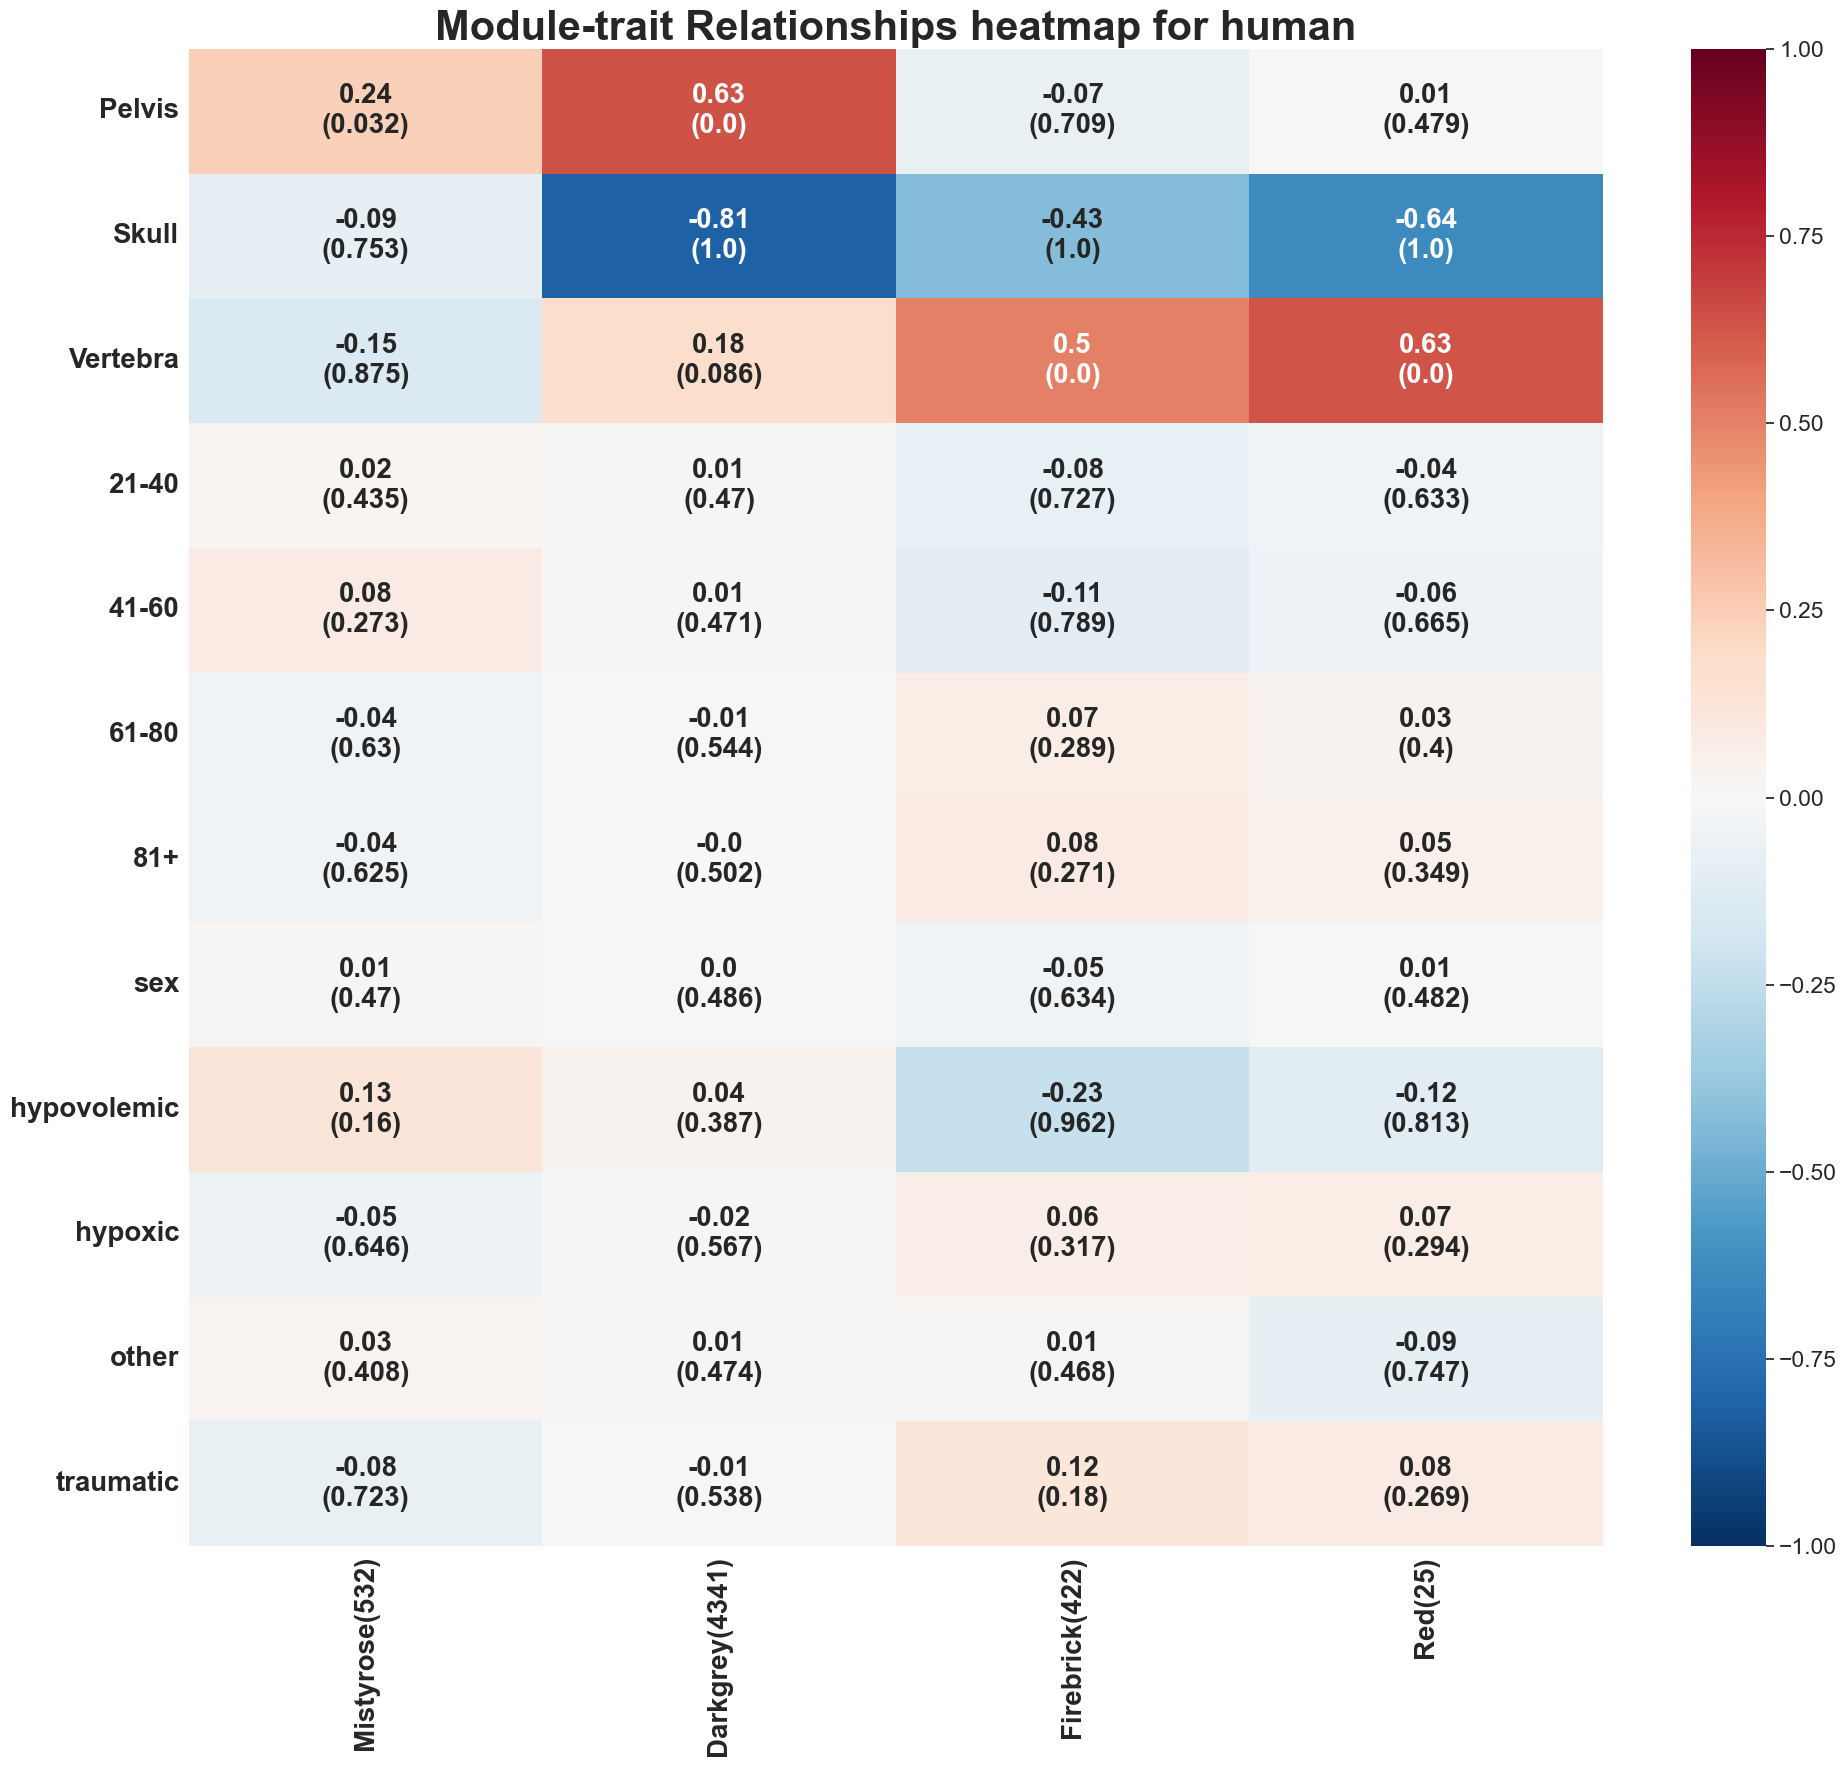

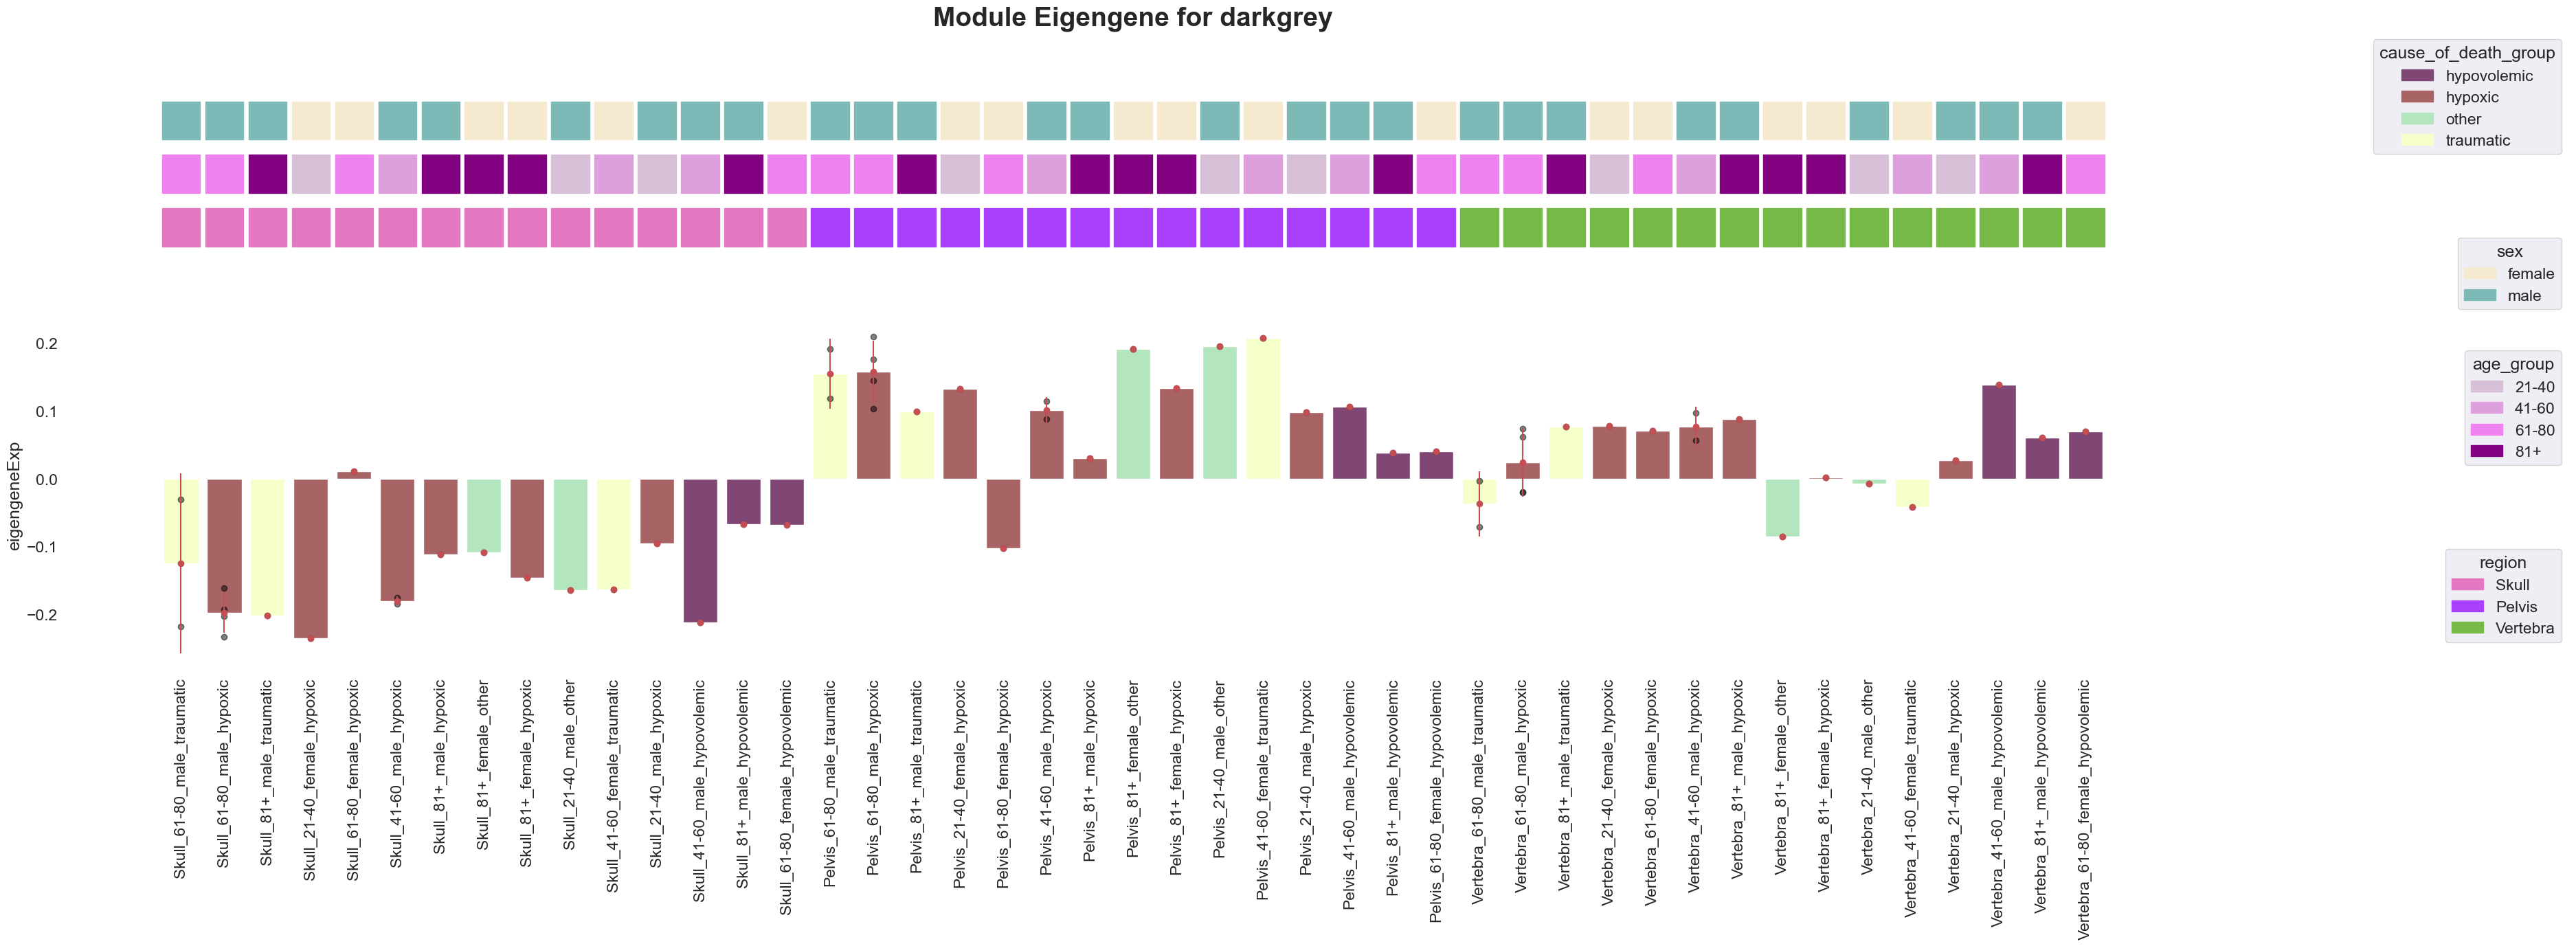

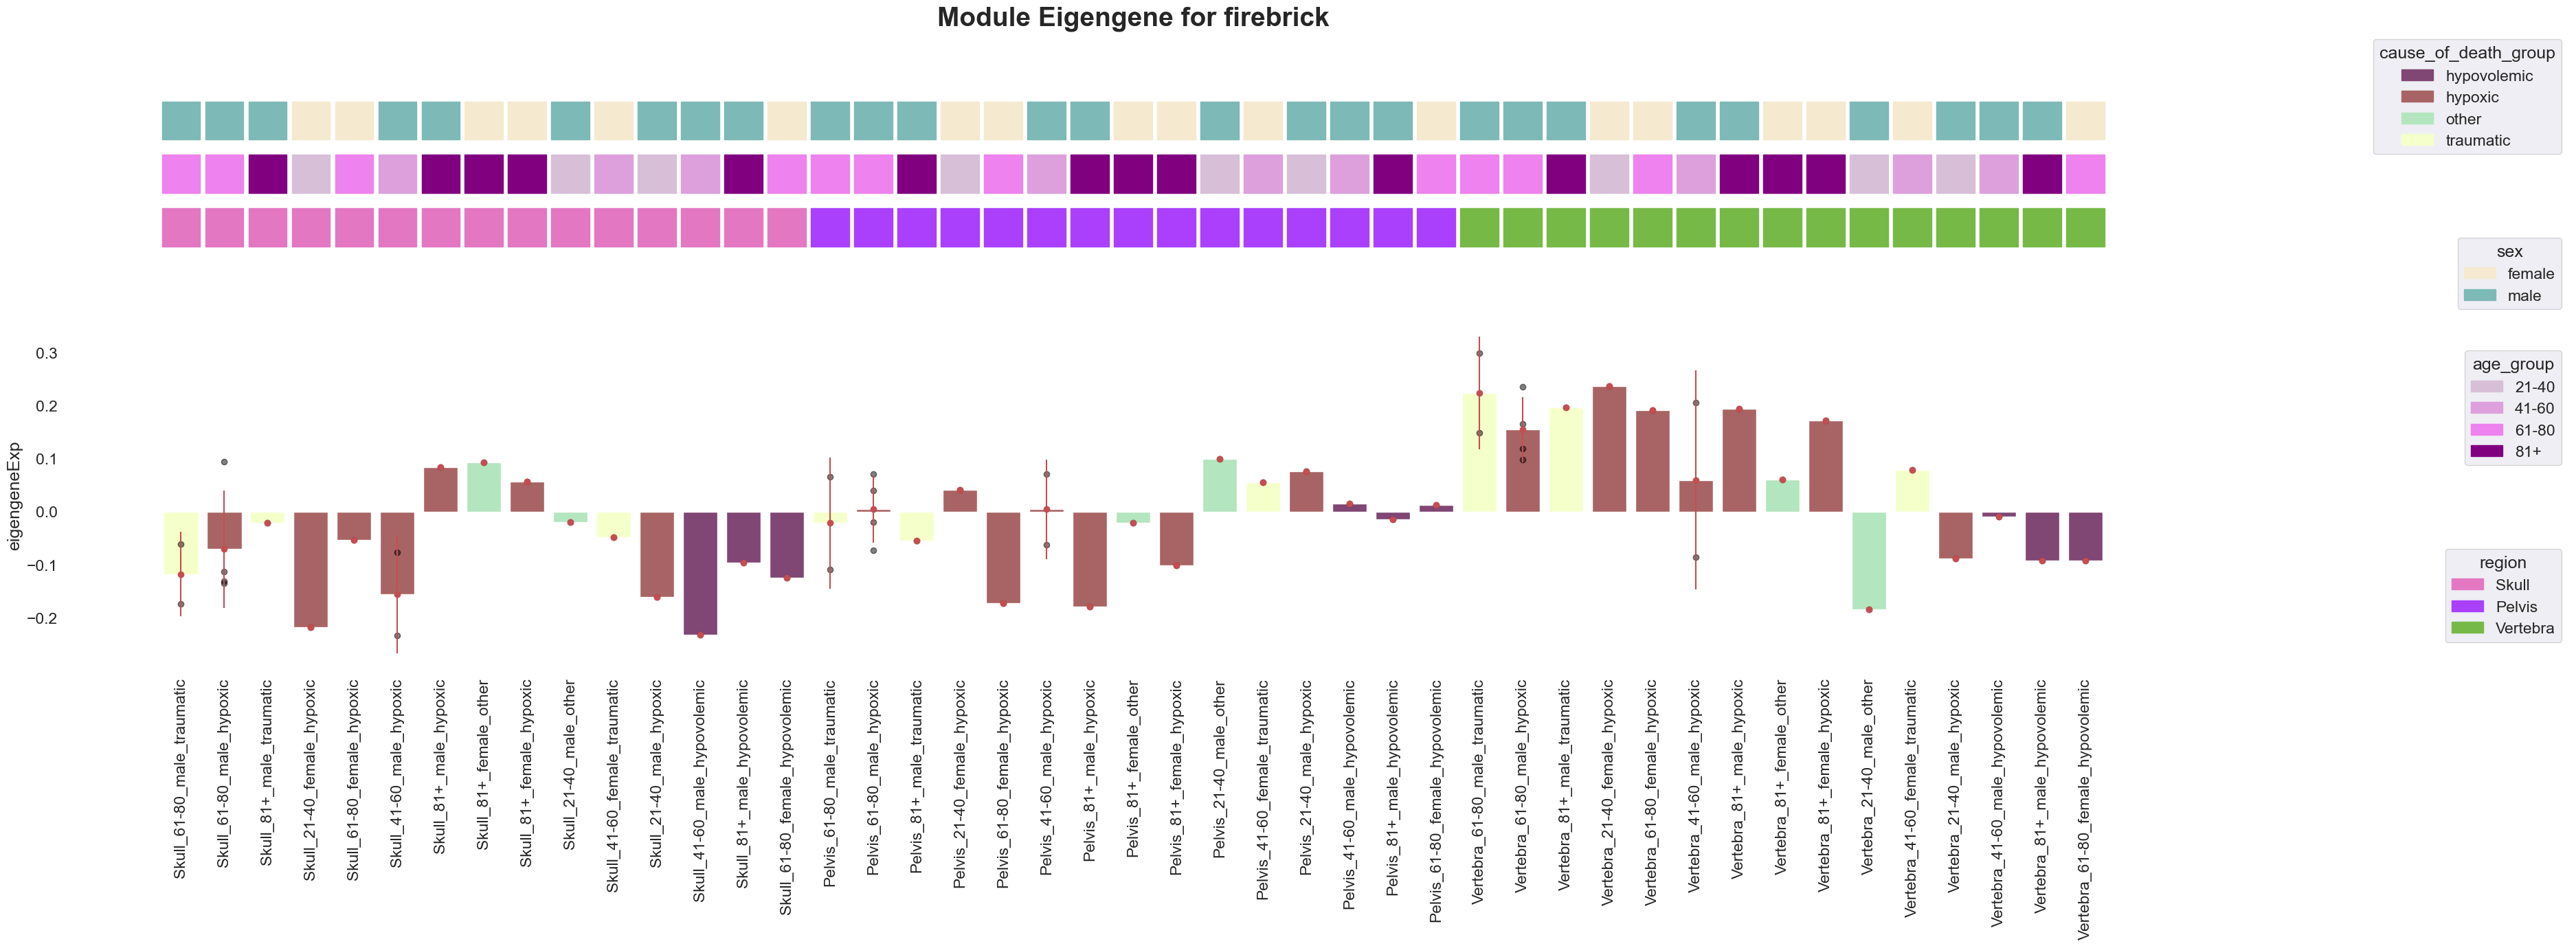

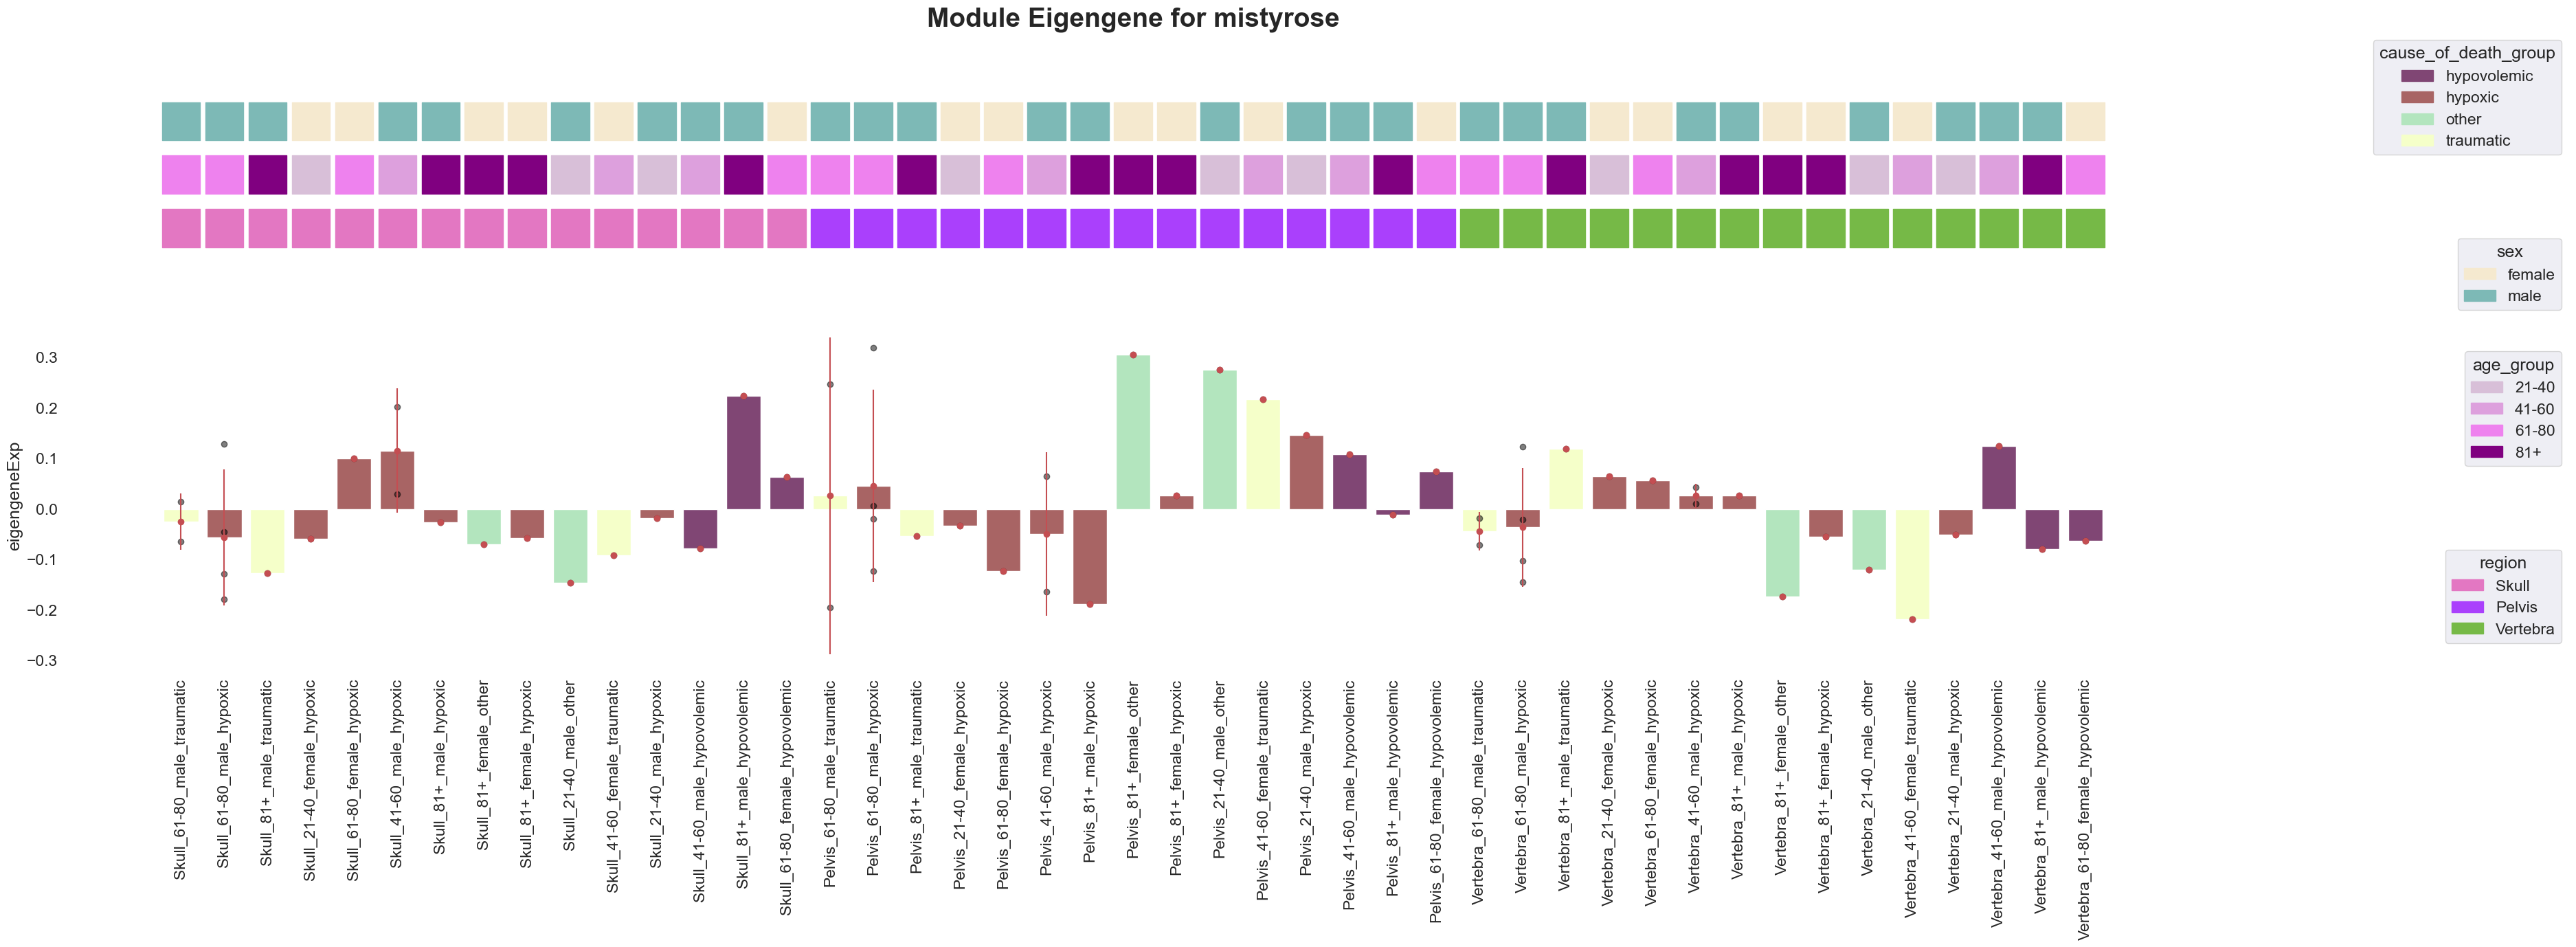

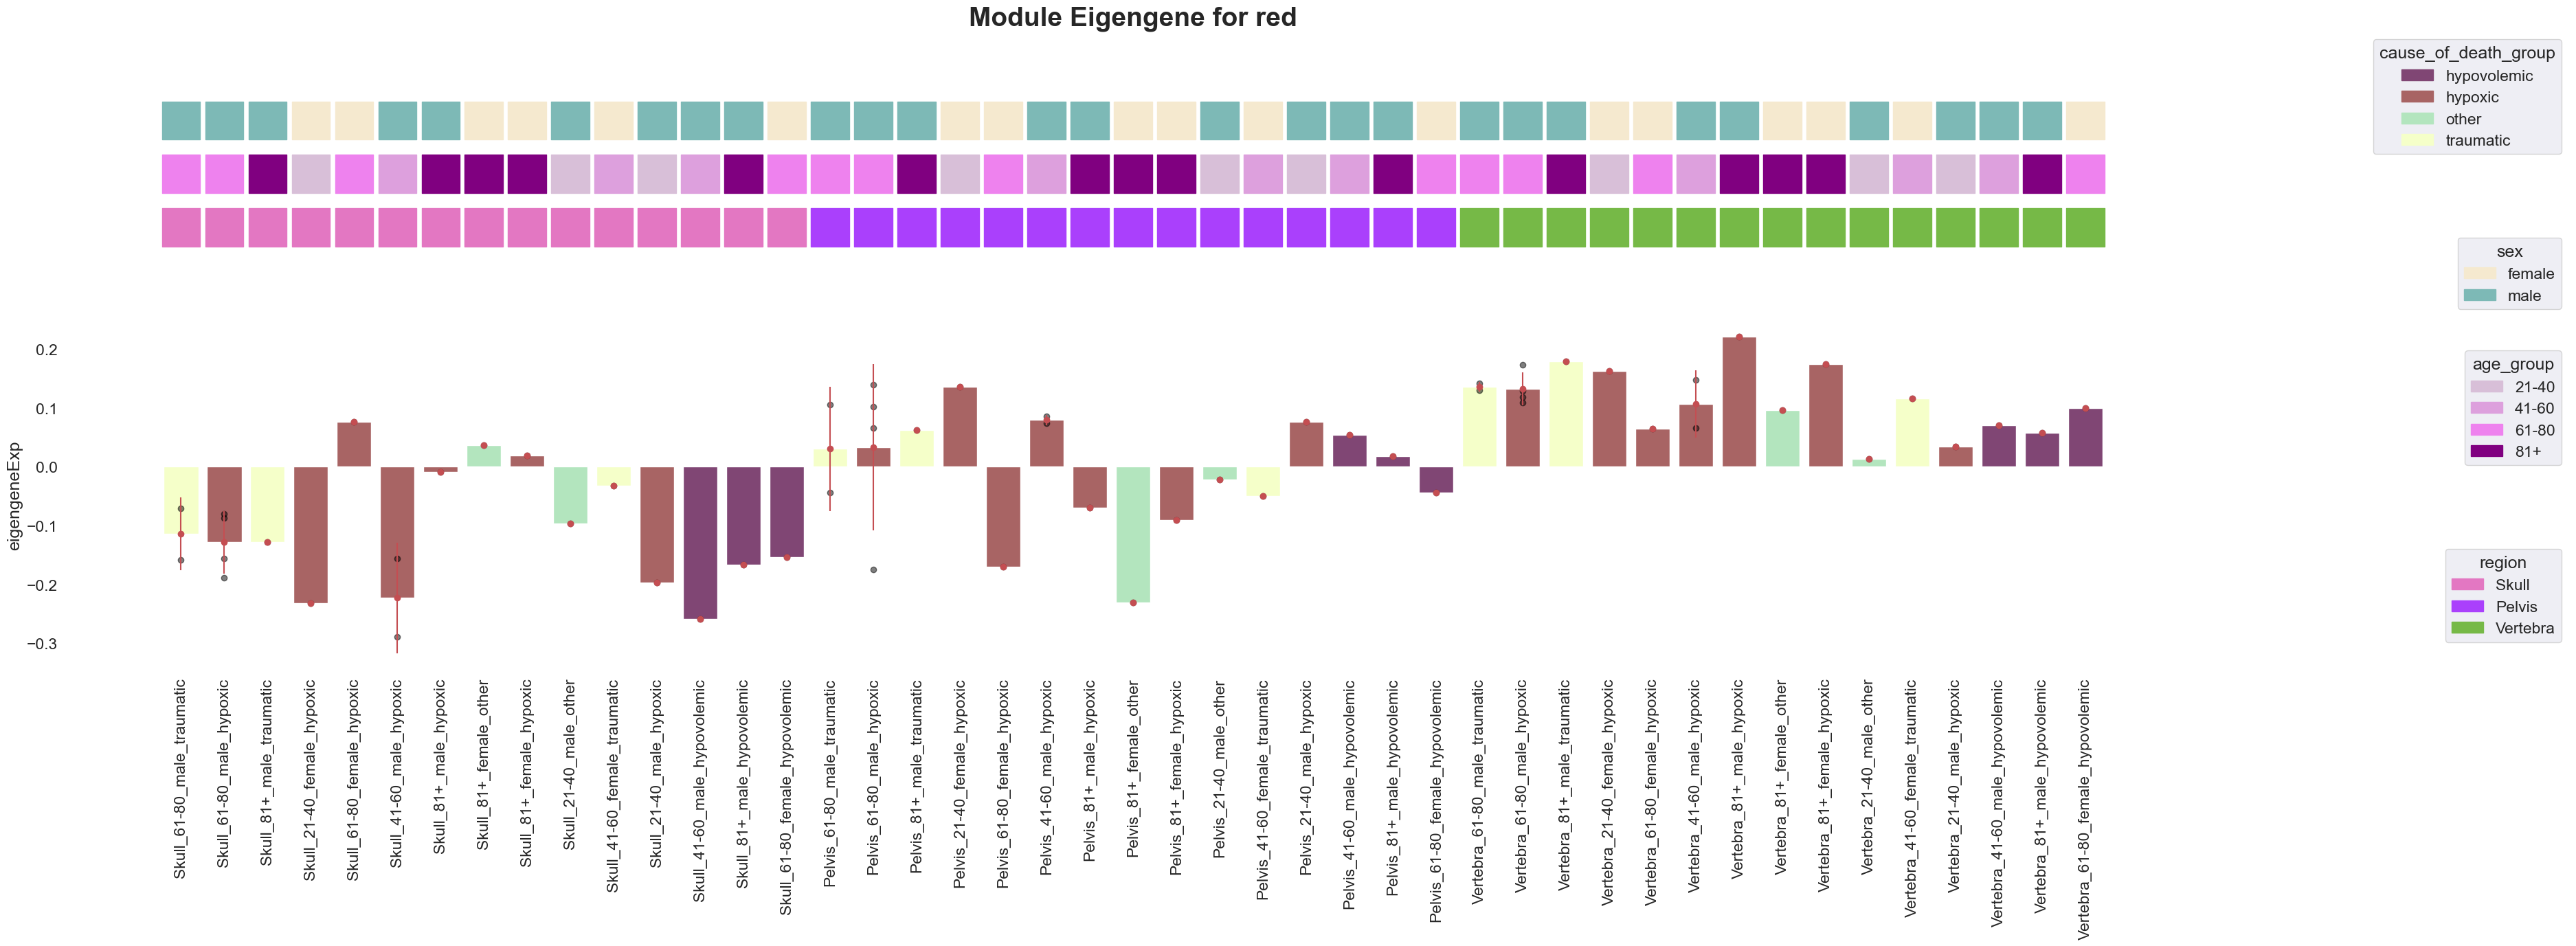

In [18]:
pyWGCNA_human.analyseWGCNA(geneList=geneList)

In [78]:
pyWGCNA_human.saveWGCNA()

Saving WGCNA as human.p


In [9]:
pyWGCNA_human = PyWGCNA.readWGCNA("human.p")

Reading human WGCNA done!


In [14]:
# add color for metadata
pyWGCNA_human.setMetadataColor('sex', {'female': '#F6F7C1',
                                       'male': '#7DB9B6',})
pyWGCNA_human.setMetadataColor('region', {'Skull': _color_Calvaria,
                                          'Pelvis': _color_Pelvis,
                                          'Vertebra': _color_Vertebra,
                                         })
pyWGCNA_human.setMetadataColor('age_group', {'21-40': 'thistle',
                                             '41-60': 'plum',
                                             '61-80': 'violet',
                                             '81+': 'purple',
                                            })
pyWGCNA_human.setMetadataColor('cause_of_death_group', {'hypovolemic': '#40513B',
                                          'hypoxic': '#609966',
                                          'traumatic': '#9DC08B',
                                          'other': '#EDF1D6',
                            })


In [15]:
samples_info.columns.tolist()

['region', 'age_group', 'sex', 'cause_of_death_group']

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

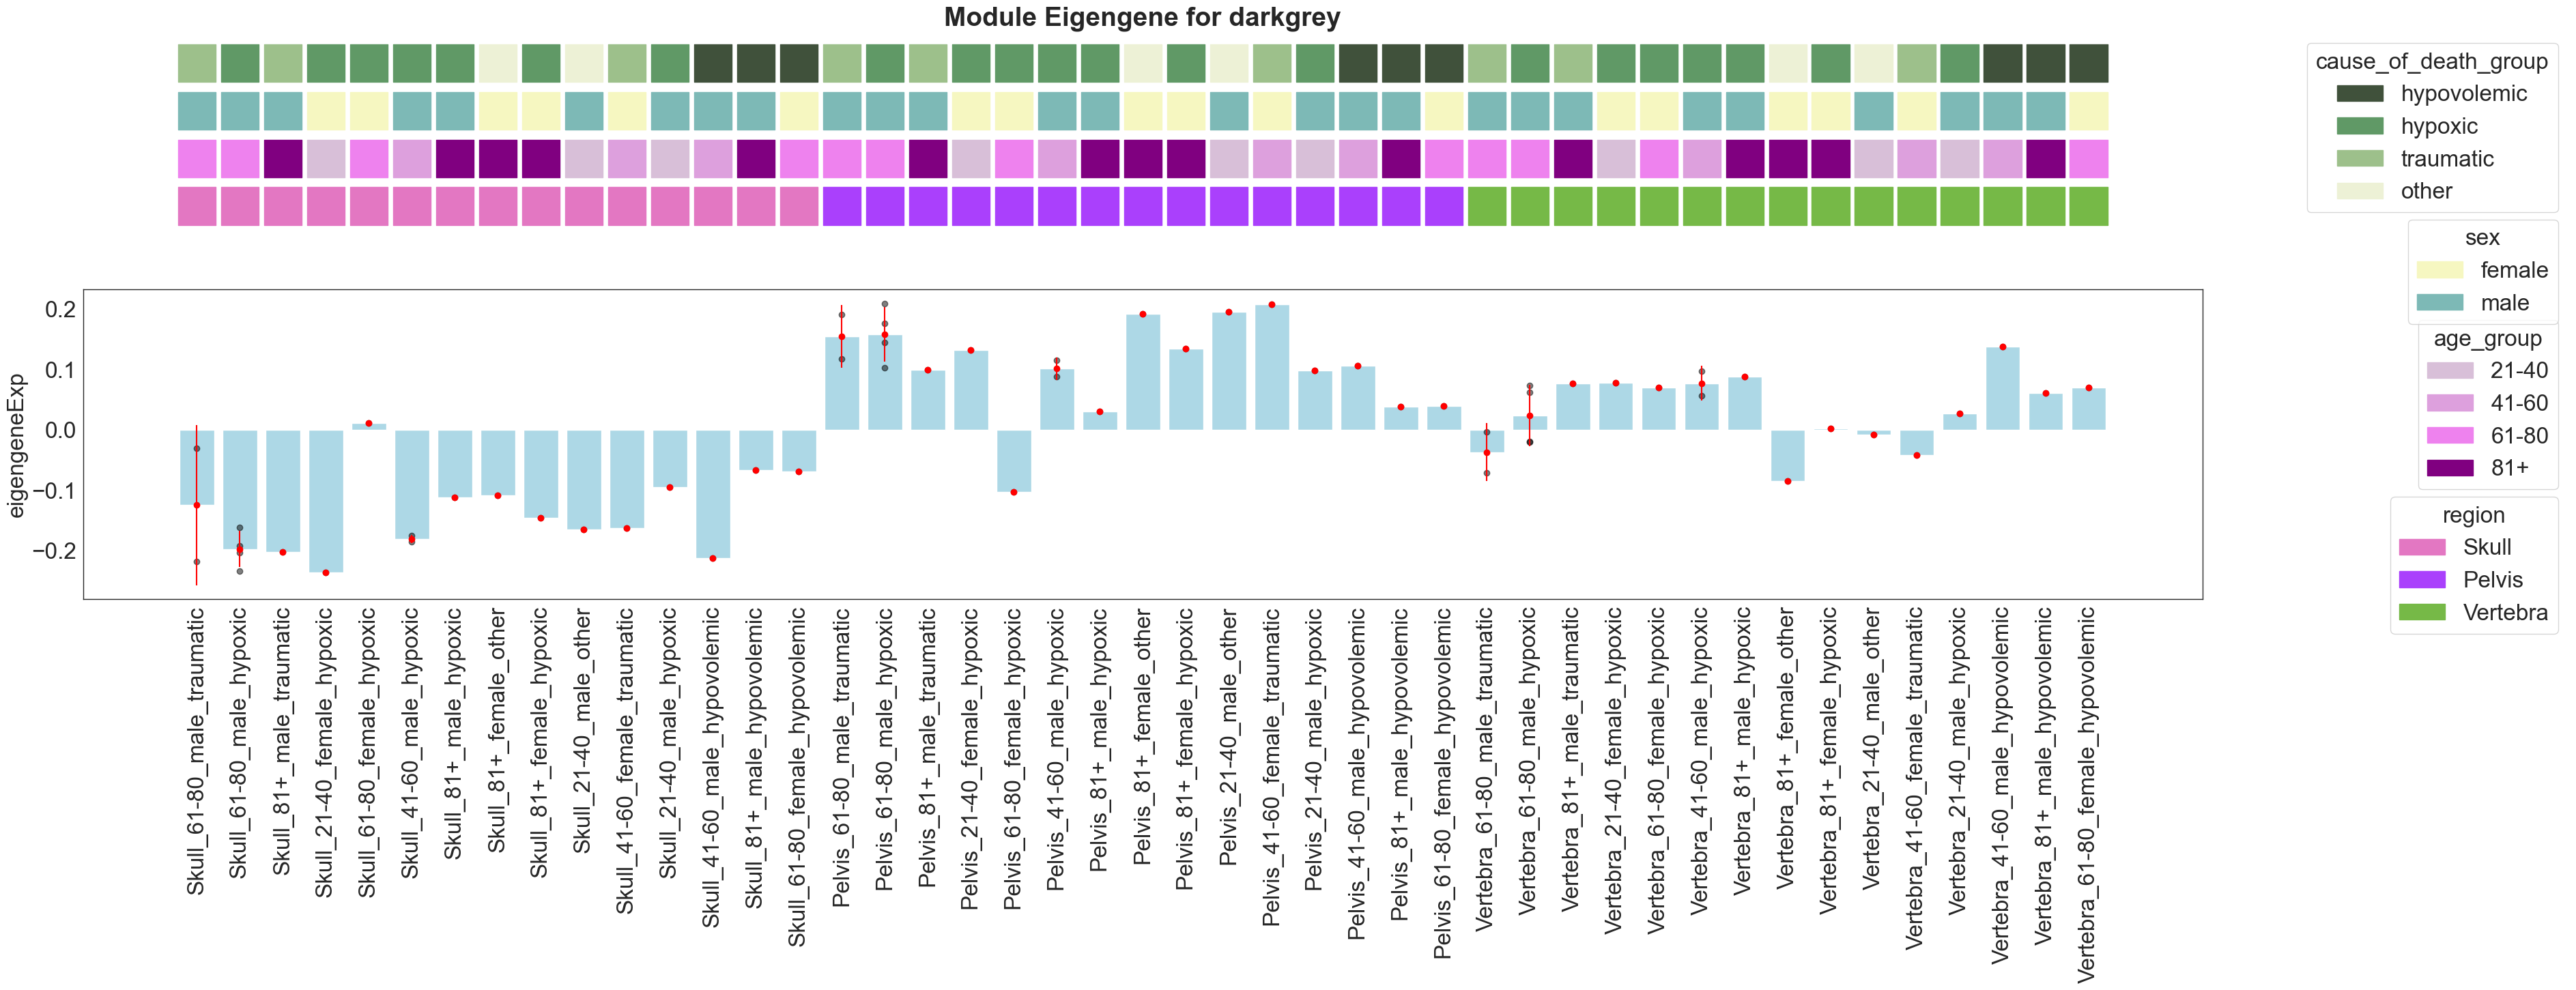

In [20]:
pyWGCNA_human.barplotModuleEigenGene(moduleName="darkgrey", metadata=samples_info.columns.tolist(), 
                                     font_size=24,
                                     bottom_pad=0.36,
                                    )

In [55]:
genes = pyWGCNA_human.datExpr[:, pyWGCNA_human.datExpr.var["moduleColors"] == "darkgrey"].var_names.tolist()

In [91]:
pyWGCNA_human.figureType = "pdf"
gene_set_library = ["GO_Biological_Process_2021", "GO_Cellular_Component_2021", "GO_Molecular_Function_2021"]
pyWGCNA_human.functional_enrichment_analysis(type="GO",
                                             moduleName="darkgrey",
#                                              sets=gene_set_library,
                                             p_value=0.05,
                                             file_name="GO_darkgrey")

In [4]:
GO_TERMS_FILE_NAME = ""
darkgrey_GO = pd.read_csv(GO_TERMS_FILE_NAME, delimiter='\t')

In [5]:
from enrichr_plotting import plot_gene_enrichment

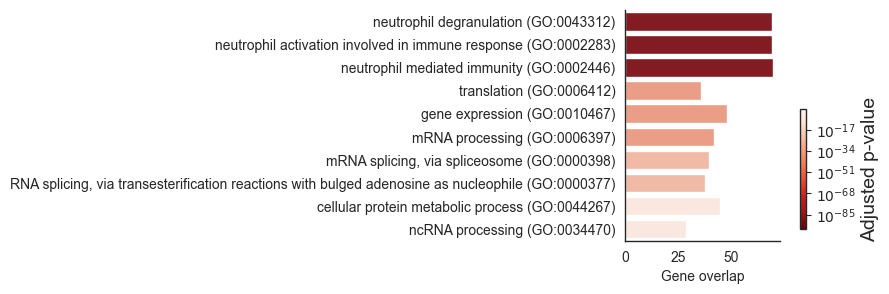

In [6]:
plot_gene_enrichment(darkgrey_GO, plot=True)